In [1]:
# # contexts와 target을 구하는 함수 만들기 , mynlp.py에 추가해 놓는다

# def create_contexts_target(corpus, window_size=1):
#     target = corpus[window_size:-window_size]
#     contexts = []

#     for idx in range(window_size, len(corpus)-window_size):
#         cs = []
#         for t in range(-window_size, window_size + 1):
#             if t == 0:
#                 continue
#             cs.append(corpus[idx + t])
#         contexts.append(cs)

#     return np.array(contexts), np.array(target)

In [2]:
# # 원핫 변환 함수  # mynlp.py 에 추가해 놓는다

# # target [1 2 3 4 1 5]을 변환하는 경우 설명 
# def convert_one_hot(corpus, vocab_size):  # [1 2 3 4 1 5], 7
#     N = corpus.shape[0] # (6,) --> 6

#     if corpus.ndim == 1: # target [1 2 3 4 1 5], 1차원인경우 ==> 2차원으로 출력
#         one_hot = np.zeros((N, vocab_size), dtype=np.int32) # 0으로 초기화된 (6,7) 2차원 배열 생성 
#         for idx, word_id in enumerate(corpus): # 6회 반복
#             one_hot[idx, word_id] = 1  # one_hot[0,1] = 1, [1,2]=1, [2,3] = 1,...,  [3,4],[4,1],[5,5] = 1...

#     elif corpus.ndim == 2: # contexts 2차원 인경우 ==> 3차원으로 출력
#         C = corpus.shape[1] # (6,2) --> 2
#         one_hot = np.zeros((N, C, vocab_size), dtype=np.int32) # 0으로 초기화된 (6,2,7) 3차원 배열 생성 
#         for idx_0, word_ids in enumerate(corpus): # 6회
#             for idx_1, word_id in enumerate(word_ids): #  2회
#                 one_hot[idx_0, idx_1, word_id] = 1  

#     return one_hot

### Trainer 클래스  : nn_layers에 추가해 놓는다

In [3]:
# import time

# def remove_duplicate(params, grads):
#     '''
#     매개변수의 중복 제거 함수
#     매개변수 배열 중 중복되는 가중치를 하나로 모아
#     그 가중치에 대응하는 기울기를 더한다.
#     '''
#     params, grads = params[:], grads[:]  # copy list

#     while True:
#         find_flg = False
#         L = len(params)

#         for i in range(0, L - 1):
#             for j in range(i + 1, L):
#                 # 가중치 공유 시
#                 if params[i] is params[j]:
#                     grads[i] += grads[j]  # 경사를 더함
#                     find_flg = True
#                     params.pop(j)
#                     grads.pop(j)
#                 # 가중치를 전치행렬로 공유하는 경우(weight tying)
#                 elif params[i].ndim == 2 and params[j].ndim == 2 and \
#                      params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
#                     grads[i] += grads[j].T
#                     find_flg = True
#                     params.pop(j)
#                     grads.pop(j)

#                 if find_flg: break
#             if find_flg: break

#         if not find_flg: break

#     return params, grads


# class Trainer:
#     def __init__(self, model, optimizer):
#         self.model = model
#         self.optimizer = optimizer
#         self.loss_list = []
#         self.eval_interval = None
#         self.current_epoch = 0

#     def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
#         data_size = len(x)
#         max_iters = data_size // batch_size
#         self.eval_interval = eval_interval
#         model, optimizer = self.model, self.optimizer
#         total_loss = 0
#         loss_count = 0

#         start_time = time.time()
#         for epoch in range(max_epoch):
#             # 뒤섞기
#             idx = np.random.permutation(np.arange(data_size))
#             x = x[idx]
#             t = t[idx]

#             for iters in range(max_iters):
#                 batch_x = x[iters*batch_size:(iters+1)*batch_size]
#                 batch_t = t[iters*batch_size:(iters+1)*batch_size]

#                 # 기울기 구해 매개변수 갱신
#                 loss = model.forward(batch_x, batch_t)
#                 model.backward()
                
#                 params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
#                 if max_grad is not None:
#                     clip_grads(grads, max_grad)
#                 optimizer.update(params, grads)
#                 total_loss += loss
#                 loss_count += 1

#                 # 평가
#                 if (eval_interval is not None) and (iters % eval_interval) == 0:
#                     avg_loss = total_loss / loss_count
#                     elapsed_time = time.time() - start_time
#                     print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
#                           % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
#                     self.loss_list.append(float(avg_loss))
#                     total_loss, loss_count = 0, 0

#             self.current_epoch += 1

#     def plot(self, ylim=None):
#         x = np.arange(len(self.loss_list))
#         if ylim is not None:
#             plt.ylim(*ylim)
#         plt.plot(x, self.loss_list, label='train')
#         plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
#         plt.ylabel('손실')
#         plt.show()
       

#  skip-gram모델 구현

In [4]:
from mynlp import preprocess, create_co_matrix, cos_similarity, most_similar, create_contexts_target, convert_one_hot
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

from nn_layers import  MatMul, SoftmaxWithLoss,Adam,SGD, Trainer


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):  # 어휘 수 : 7개, 은닉 층의 뉴런수 5
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)   # (6,7)*(7,5) = (6,5)
        self.out_layer = MatMul(W_out) # (6,5)*(5,7) = (6,7) 
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def predict(self,target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
#         c1 = self.loss_layer1.softmax(s)
#         c2 = self.loss_layer2.softmax(s)
        return s # c1,c2 # self.loss_layer1.softmax(s) #softmax로 변화

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[0 1 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0]
[0 1 0 1 0 0 0 0]
[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
0.7071067691154799
[0 1 0 1 0 0 0]
[0 1 0 0 0 0 1]
0.49999999292893216

[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0
[[0.07762524 0.50133058 0.2086436  0.10040436 0.01438839 0.73476126
  0.95306039 0.66423624]] (1, 8)
----------------------------------------------------------------------
[[0.07762524 0.50133058 0.2086436  0.10040436 0.01438839 0.73476126
  0.95306039 0.66423624]
 [0.07762524 0.50133058 0.2086436  0.10040436 0.01438839 0.73476126
  0.95306039 0.66423624]
 [0.07762524 0.50133058 0.2086436  0.10040436 0.01438839 0.73476126
  0.95306039 0.66423624]
 [0.07762524 0.50133058 0.2086436  0.10040436 0.01438839 0.73476126
  0.95306039 0.66423624]
 [0.07762524 0.50133058 0.2086436  0.10040436 0.01438839 0.73476126
  0.95306039 0.66423624]
 [0

### 학습 코드 구현

In [5]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(target)
print(contexts)
# 중앙의 단어(타깃)으로부터 주변의 여러 단어(맥락)를 예측한다

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [6]:
model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.87
| 에폭 26 |

| 에폭 231 |  반복 1 / 2 | 시간 0[s] | 손실 2.68
| 에폭 232 |  반복 1 / 2 | 시간 0[s] | 손실 2.63
| 에폭 233 |  반복 1 / 2 | 시간 0[s] | 손실 2.68
| 에폭 234 |  반복 1 / 2 | 시간 0[s] | 손실 2.57
| 에폭 235 |  반복 1 / 2 | 시간 0[s] | 손실 2.55
| 에폭 236 |  반복 1 / 2 | 시간 0[s] | 손실 2.62
| 에폭 237 |  반복 1 / 2 | 시간 0[s] | 손실 2.62
| 에폭 238 |  반복 1 / 2 | 시간 0[s] | 손실 2.74
| 에폭 239 |  반복 1 / 2 | 시간 0[s] | 손실 2.56
| 에폭 240 |  반복 1 / 2 | 시간 0[s] | 손실 2.54
| 에폭 241 |  반복 1 / 2 | 시간 0[s] | 손실 2.61
| 에폭 242 |  반복 1 / 2 | 시간 0[s] | 손실 2.68
| 에폭 243 |  반복 1 / 2 | 시간 0[s] | 손실 2.60
| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 2.47
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 2.73
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 2.59
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 2.53
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 2.64
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 2.51
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 2.66
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 2.58
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 2.66
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 2.50
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 2.57
| 에폭 255 |  반복 1

| 에폭 556 |  반복 1 / 2 | 시간 0[s] | 손실 2.48
| 에폭 557 |  반복 1 / 2 | 시간 0[s] | 손실 2.12
| 에폭 558 |  반복 1 / 2 | 시간 0[s] | 손실 2.16
| 에폭 559 |  반복 1 / 2 | 시간 0[s] | 손실 2.48
| 에폭 560 |  반복 1 / 2 | 시간 0[s] | 손실 2.00
| 에폭 561 |  반복 1 / 2 | 시간 0[s] | 손실 2.69
| 에폭 562 |  반복 1 / 2 | 시간 0[s] | 손실 2.32
| 에폭 563 |  반복 1 / 2 | 시간 0[s] | 손실 2.27
| 에폭 564 |  반복 1 / 2 | 시간 0[s] | 손실 2.21
| 에폭 565 |  반복 1 / 2 | 시간 0[s] | 손실 2.32
| 에폭 566 |  반복 1 / 2 | 시간 0[s] | 손실 2.48
| 에폭 567 |  반복 1 / 2 | 시간 0[s] | 손실 2.11
| 에폭 568 |  반복 1 / 2 | 시간 0[s] | 손실 2.31
| 에폭 569 |  반복 1 / 2 | 시간 0[s] | 손실 2.37
| 에폭 570 |  반복 1 / 2 | 시간 0[s] | 손실 2.32
| 에폭 571 |  반복 1 / 2 | 시간 0[s] | 손실 2.11
| 에폭 572 |  반복 1 / 2 | 시간 0[s] | 손실 2.68
| 에폭 573 |  반복 1 / 2 | 시간 0[s] | 손실 2.32
| 에폭 574 |  반복 1 / 2 | 시간 0[s] | 손실 2.36
| 에폭 575 |  반복 1 / 2 | 시간 0[s] | 손실 2.22
| 에폭 576 |  반복 1 / 2 | 시간 0[s] | 손실 2.20
| 에폭 577 |  반복 1 / 2 | 시간 0[s] | 손실 2.31
| 에폭 578 |  반복 1 / 2 | 시간 0[s] | 손실 2.31
| 에폭 579 |  반복 1 / 2 | 시간 0[s] | 손실 2.26
| 에폭 580 |  반복 1

| 에폭 895 |  반복 1 / 2 | 시간 0[s] | 손실 2.29
| 에폭 896 |  반복 1 / 2 | 시간 0[s] | 손실 1.87
| 에폭 897 |  반복 1 / 2 | 시간 0[s] | 손실 2.20
| 에폭 898 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 899 |  반복 1 / 2 | 시간 0[s] | 손실 2.17
| 에폭 900 |  반복 1 / 2 | 시간 0[s] | 손실 2.19
| 에폭 901 |  반복 1 / 2 | 시간 0[s] | 손실 1.74
| 에폭 902 |  반복 1 / 2 | 시간 0[s] | 손실 2.28
| 에폭 903 |  반복 1 / 2 | 시간 0[s] | 손실 1.98
| 에폭 904 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 905 |  반복 1 / 2 | 시간 0[s] | 손실 2.18
| 에폭 906 |  반복 1 / 2 | 시간 0[s] | 손실 1.85
| 에폭 907 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 908 |  반복 1 / 2 | 시간 0[s] | 손실 2.28
| 에폭 909 |  반복 1 / 2 | 시간 0[s] | 손실 1.84
| 에폭 910 |  반복 1 / 2 | 시간 0[s] | 손실 2.21
| 에폭 911 |  반복 1 / 2 | 시간 0[s] | 손실 2.06
| 에폭 912 |  반복 1 / 2 | 시간 0[s] | 손실 2.06
| 에폭 913 |  반복 1 / 2 | 시간 0[s] | 손실 2.27
| 에폭 914 |  반복 1 / 2 | 시간 0[s] | 손실 1.72
| 에폭 915 |  반복 1 / 2 | 시간 0[s] | 손실 2.20
| 에폭 916 |  반복 1 / 2 | 시간 0[s] | 손실 2.27
| 에폭 917 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 918 |  반복 1 / 2 | 시간 0[s] | 손실 1.82
| 에폭 919 |  반복 1

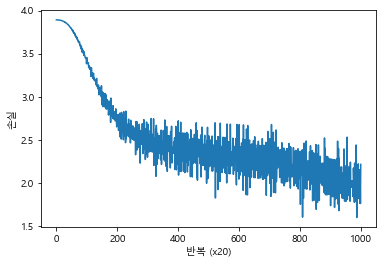

In [7]:
trainer.plot()

In [8]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print('%10s : '%word, word_vecs[word_id])    

       you :  [ 0.00821368  0.00698756 -0.00775601 -0.01314396 -0.01118343]
       say :  [-0.3739031  -1.3928835  -0.35688812 -0.12305597 -0.4563853 ]
   goodbye :  [0.9007231 1.0419877 1.0794154 0.6932717 0.8207725]
       and :  [-1.1833463  -0.45133957 -1.1342839  -1.2596629  -1.1467117 ]
         i :  [0.8980019  1.0519845  1.0811661  0.7045286  0.81961524]
     hello :  [ 0.46739778 -0.0792076  -0.36352295  1.2621821   0.9117487 ]
         . :  [ 0.01689683 -0.00274418  0.00383859  0.01246603  0.00581432]


## 예측 및 정확도 평가

In [9]:
h = model.predict(target[0,:])  # [0 1 0 0 0 0 0] ,'say'
# print(h.shape)
# print(h)
pred0 = np.argmax(h,0)
h1 = h
h[pred0] = 0
pred1 = np.argmax(h1,0)
c0 = np.argmax(contexts[0,0,:],0)
c1 = np.argmax(contexts[0,1,:],0)
print('context : ',c0,c1)       # 0,2 : 'you' 와 'goodbye'
print('predict : ',pred0,pred1)  # 2,4 : 'goodbye' 와 'i'
print('-'*50)

h = model.predict(target[1,:])  # [0 0 1 0 0 0 0] ,'goobye'
pred0 = np.argmax(h,0)
h1 = h
h[pred0] = 0
pred1 = np.argmax(h1,0)
c0 = np.argmax(contexts[1,0,:],0) # 1,3 : 'say' 와 'and'
c1 = np.argmax(contexts[1,1,:],0) # 1,3 : 'say' 와 'and'
print('context : ',c0,c1)
print('predict : ',pred0,pred1)
print('-'*50)

context :  0 2
predict :  4 2
--------------------------------------------------
context :  1 3
predict :  1 3
--------------------------------------------------


In [10]:
def get_correct(num):
    h = model.predict(target[num,:])  
    pred0 = np.argmax(h,0)
    h1 = h
    h[pred0] = 0
    pred1 = np.argmax(h1,0)
    c0 = np.argmax(contexts[num,0,:],0) 
    c1 = np.argmax(contexts[num,1,:],0) 
    print('context : ',c0,c1)
    print('predict : ',pred0,pred1)
    print('-'*50)
    correct = 0
    if (c0==pred0)|(c0==pred1):
        correct +=1
    if (c1==pred0)|(c1==pred1):
        correct +=1
    return correct    

acc = 0
for k in range(target.shape[0]) : # 6회
    correct = get_correct(k)
    acc += correct

accuracy = acc/target.shape[0]/2 # 12로 나눔  , 10/12 = 0.833
print('정확도 : ',np.round(accuracy,4)) # 정확도가 CBOW에 비해 비교적 높음

context :  0 2
predict :  4 2
--------------------------------------------------
context :  1 3
predict :  1 3
--------------------------------------------------
context :  2 4
predict :  4 2
--------------------------------------------------
context :  3 1
predict :  1 3
--------------------------------------------------
context :  4 5
predict :  4 2
--------------------------------------------------
context :  1 6
predict :  1 6
--------------------------------------------------
정확도 :  0.8333


In [12]:
print(contexts)
contexts.shape

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


(6, 2, 7)

In [13]:
print(contexts[0,:,:])
contexts.shape

[[1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]]


(6, 2, 7)

In [14]:
print(target[0,:])
target.shape

[0 1 0 0 0 0 0]


(6, 7)